In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def generar_tabla(N=1000):
    tc = np.random.uniform(0, 1, N)
    phi_c = np.random.uniform(0, 2 * np.pi, N)
    psi = np.random.uniform(0, 2 * np.pi, N)
    RA = np.random.uniform(0, 2 * np.pi, N)
    iota = np.arccos(1 - 2 * np.random.uniform(0, 1, N))
    DEC = np.arccos(1 - 2 * np.random.uniform(0, 1, N))

    tabla = pd.DataFrame({
        'tc': tc,
        'phi_c': phi_c,
        'psi': psi,
        'RA': RA,
        'iota': iota,
        'DEC': DEC
    })

    return tabla

parametros = generar_tabla(1000)
print(parametros.head())


         tc     phi_c       psi        RA      iota       DEC
0  0.820991  5.944293  3.033471  1.941067  1.087571  1.649873
1  0.189901  4.606443  2.102979  2.803732  2.617940  1.347438
2  0.789116  5.855193  5.161717  0.571574  1.889994  1.908674
3  0.730473  4.635309  0.556795  5.860581  1.845659  0.667059
4  0.034931  5.753468  0.030901  2.718589  2.409658  2.251226


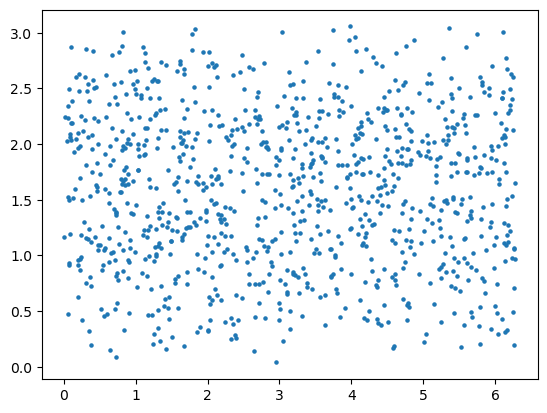

In [3]:
plt.scatter(parametros['RA'], parametros['DEC'], s=5)

C:\Users\juanf\AppData\Local\Temp\ipykernel_80452\3873040114.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)
C:\Users\juanf\AppData\Local\Temp\ipykernel_80452\3873040114.py:28: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])


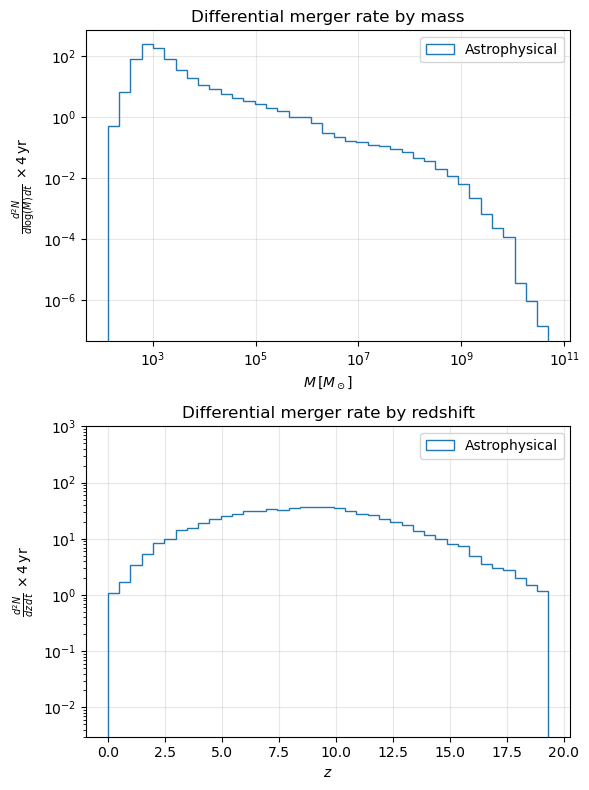

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from scipy import integrate
from scipy.integrate import simps


file_path = "popIII_K16.dat.bz2"

column_names = ["z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "psi", "afin", "mfin", "vkick", "vesc_halo", "vesc_bar", "Mcluster", "Mdisk_stars", "Mdisk_gas", "Mbulge_stars", "Mbulge_gas", "MNSC", "Mreservoir", "Mhalo_final", "halo_density"]

data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)

#c = 299792  # Velocidad de la luz en km/s
c = 9.72e-15  # Velocidad de la luz en Mpc/s
 

# ------ Se calcula la distancia luminica ------
def luminosity_distance(z):
    return cosmo.luminosity_distance(z).value  # Calcula la distancia luminica con cosmologia basada en Planck 2018 (H0 = 67.4km/s/Mpc , Ωm = 0.315, ΩΛ = 0.685)
    
data["DL"] = data["z_merger"].apply(luminosity_distance)

# ------ Luego se calcula d^2N/dzdt --------
data["d2N_dzdt"] = (4 * np.pi * c * data["halo_density"] * data["DL"]**2 / ((1 + data["z_merger"])**2))

data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])

# ------ Se ordenann los datos para crear los histogramas para las distribuciones ---------
# Histograma de redshift
z_bins = np.linspace(data["z_merger"].min(), data["z_merger"].max(), 40)
#z_hist, z_edges = np.histogram(data["z_merger"], bins=z_bins, weights=data["d2N_dzdt"])

# Histograma de masa total
data["total_mass"] = data["m1"] + data["m2"]
mass_bins = np.logspace(np.log10(data["total_mass"].min()), np.log10(data["total_mass"].max()), 40)
mass_hist, mass_edges = np.histogram(data["total_mass"], bins=mass_bins, weights=data["d2N_dzdt"])


#----- Aplicar gaussiana en z ------
sigma_z = 0.7 
data["z_merger_noisy"] = data["z_merger"] + np.random.normal(0, sigma_z, len(data))

z_hist, z_edges = np.histogram(data["z_merger_noisy"], bins=z_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (mass_edges[:-1] + mass_edges[1:]), 
    bins=mass_bins,
    weights=mass_hist *3600* 24 * 365 *4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$M \, [M_\odot]$")
axs[0].set_ylabel(r"$\frac{d^2N}{d\log(M) \, dt} \, \times 4 \, \text{yr}$")
axs[0].set_title("Differential merger rate by mass")
axs[0].grid(alpha=0.3)
axs[0].legend()

axs[1].hist(
    0.5 * (z_edges[:-1] + z_edges[1:]),  
    bins=z_bins,
    weights=z_hist *3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$")
axs[1].set_ylabel(r"$\frac{d^2N}{dz \, dt} \, \times 4 \, \text{yr}$")
axs[1].set_title("Differential merger rate by redshift")
axs[1].grid(alpha=0.3)
axs[1].set_ylim(0.003, 1000)
axs[1].legend()

plt.tight_layout()
plt.show()


C:\Users\juanf\AppData\Local\Temp\ipykernel_80452\3873040114.py:13: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)
C:\Users\juanf\AppData\Local\Temp\ipykernel_80452\3873040114.py:28: DeprecationWarning: 'scipy.integrate.simps' is deprecated in favour of 'scipy.integrate.simpson' and will be removed in SciPy 1.14.0
  data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])


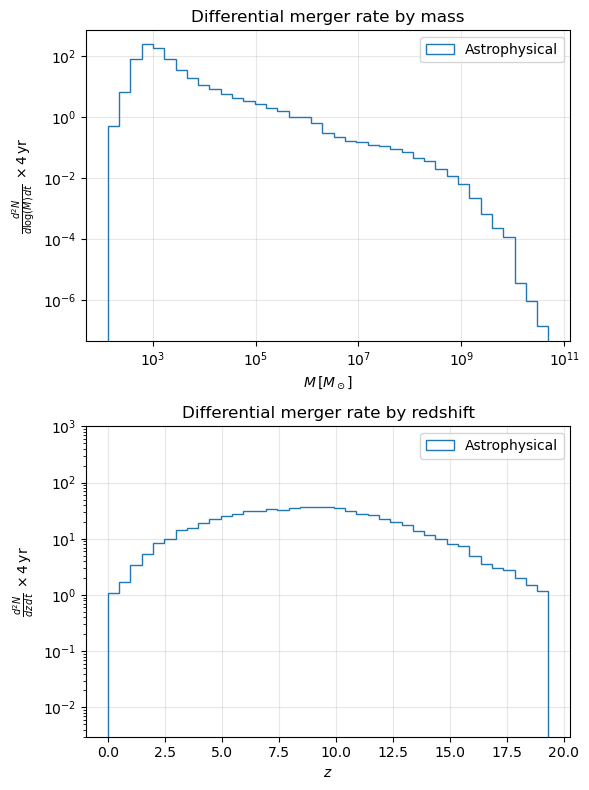

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from scipy import integrate
from scipy.integrate import simps


file_path = "popIII_K16.dat.bz2"

column_names = ["z_merger", "m1", "m2", "a1", "a2", "alpha", "beta", "gamma", "psi", "afin", "mfin", "vkick", "vesc_halo", "vesc_bar", "Mcluster", "Mdisk_stars", "Mdisk_gas", "Mbulge_stars", "Mbulge_gas", "MNSC", "Mreservoir", "Mhalo_final", "halo_density"]

data = pd.read_csv(file_path, delim_whitespace=True, names=column_names)

#c = 299792  # Velocidad de la luz en km/s
c = 9.72e-15  # Velocidad de la luz en Mpc/s
 

# ------ Se calcula la distancia luminica ------
def luminosity_distance(z):
    return cosmo.luminosity_distance(z).value  # Calcula la distancia luminica con cosmologia basada en Planck 2018 (H0 = 67.4km/s/Mpc , Ωm = 0.315, ΩΛ = 0.685)
    
data["DL"] = data["z_merger"].apply(luminosity_distance)

# ------ Luego se calcula d^2N/dzdt --------
data["d2N_dzdt"] = (4 * np.pi * c * data["halo_density"] * data["DL"]**2 / ((1 + data["z_merger"])**2))

data["dN_dt"] = simps(data["d2N_dzdt"], data["z_merger"])

# ------ Se ordenann los datos para crear los histogramas para las distribuciones ---------
# Histograma de redshift
z_bins = np.linspace(data["z_merger"].min(), data["z_merger"].max(), 40)
#z_hist, z_edges = np.histogram(data["z_merger"], bins=z_bins, weights=data["d2N_dzdt"])

# Histograma de masa total
data["total_mass"] = data["m1"] + data["m2"]
mass_bins = np.logspace(np.log10(data["total_mass"].min()), np.log10(data["total_mass"].max()), 40)
mass_hist, mass_edges = np.histogram(data["total_mass"], bins=mass_bins, weights=data["d2N_dzdt"])


#----- Aplicar gaussiana en z ------
sigma_z = 0.7 
data["z_merger_noisy"] = data["z_merger"] + np.random.normal(0, sigma_z, len(data))

z_hist, z_edges = np.histogram(data["z_merger_noisy"], bins=z_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (mass_edges[:-1] + mass_edges[1:]), 
    bins=mass_bins,
    weights=mass_hist *3600* 24 * 365 *4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$M \, [M_\odot]$")
axs[0].set_ylabel(r"$\frac{d^2N}{d\log(M) \, dt} \, \times 4 \, \text{yr}$")
axs[0].set_title("Differential merger rate by mass")
axs[0].grid(alpha=0.3)
axs[0].legend()

axs[1].hist(
    0.5 * (z_edges[:-1] + z_edges[1:]),  
    bins=z_bins,
    weights=z_hist *3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$z$")
axs[1].set_ylabel(r"$\frac{d^2N}{dz \, dt} \, \times 4 \, \text{yr}$")
axs[1].set_title("Differential merger rate by redshift")
axs[1].grid(alpha=0.3)
axs[1].set_ylim(0.003, 1000)
axs[1].legend()

plt.tight_layout()
plt.show()


In [6]:
total_events = np.sum(mass_hist)
print(total_events * 3600* 24 * 365 * 4)

682.3182726124463


In [7]:
print(data["d2N_dzdt"])

0         4.921604e-09
1         5.679258e-09
2         4.362020e-09
3         1.517043e-09
4         1.438444e-09
              ...     
727876    7.304217e-19
727877    2.877608e-19
727878    5.347468e-19
727879    3.619478e-20
727880    4.833123e-21
Name: d2N_dzdt, Length: 727881, dtype: float64


In [8]:
print(data["dN_dt"])

0         3.496249e-08
1         3.496249e-08
2         3.496249e-08
3         3.496249e-08
4         3.496249e-08
              ...     
727876    3.496249e-08
727877    3.496249e-08
727878    3.496249e-08
727879    3.496249e-08
727880    3.496249e-08
Name: dN_dt, Length: 727881, dtype: float64


In [9]:
print(3.496249e-08 * 3600* 24 * 365 * 4)

4.410308338560001


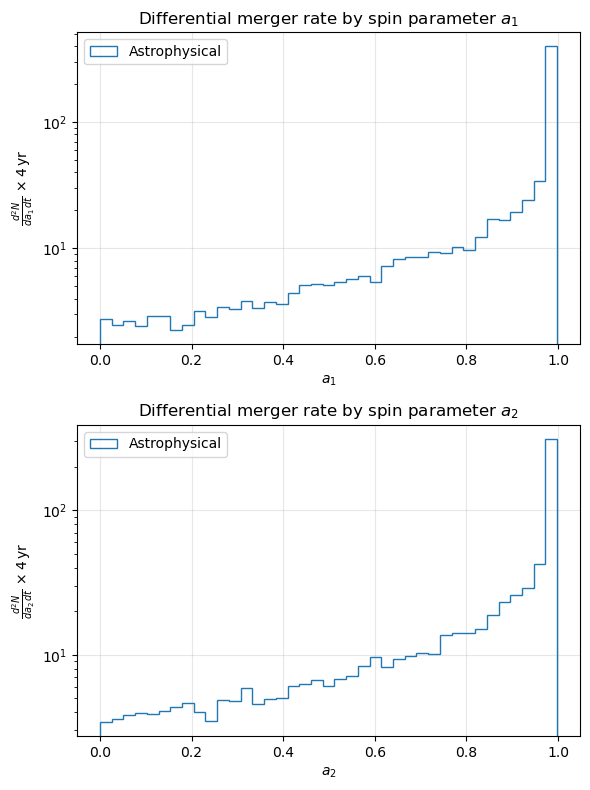

In [10]:
a1_bins = np.linspace(data["a1"].min(), data["a1"].max(), 40)
a1_hist, a1_edges = np.histogram(data["a1"], bins=a1_bins, weights=data["d2N_dzdt"])

a2_bins = np.linspace(data["a2"].min(), data["a2"].max(), 40)
a2_hist, a2_edges = np.histogram(data["a2"], bins=a2_bins, weights=data["d2N_dzdt"])

# ------ Graficar ------
fig, axs = plt.subplots(2, 1, figsize=(6, 8), sharex=False)

axs[0].hist(
    0.5 * (a1_edges[:-1] + a1_edges[1:]), 
    bins=a1_bins,
    weights=a1_hist*3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
#axs[0].set_xscale("log")
axs[0].set_yscale("log")
axs[0].set_xlabel(r"$a_1$")
axs[0].set_ylabel(r"$\frac{d^2N}{da_1 \, dt} \, \times 4 \, \text{yr}$")
axs[0].set_title(r"Differential merger rate by spin parameter $a_1$")
axs[0].grid(alpha=0.3)
axs[0].legend()

axs[1].hist(
    0.5 * (a2_edges[:-1] + a2_edges[1:]),  
    bins=a2_bins,
    weights=a2_hist*3600* 24 * 365 * 4,
    histtype='step',
    stacked=True,
    fill=False,
#    color="blue",
    label="Astrophysical"
)
axs[1].set_yscale("log")
axs[1].set_xlabel(r"$a_2$")
axs[1].set_ylabel(r"$\frac{d^2N}{da_2 \, dt} \, \times 4 \, \text{yr}$")
axs[1].set_title(r"Differential merger rate by spin parameter $a_2$")
axs[1].grid(alpha=0.3)
#axs[1].set_ylim(0.003, 1000)
axs[1].legend()

plt.tight_layout()
plt.show()


In [32]:
import pandas as pd
import numpy as np

# Factor de tiempo: años en segundos
time_factor = 3600 * 24 * 365 

# Calcular la probabilidad de ocurrencia en 4 años
data["event_probability"] = data["d2N_dzdt"] * time_factor

# Normalizar las probabilidades
probabilities = data["event_probability"] / data["event_probability"].sum()

# Determinar el número total de eventos esperados
expected_events = int(data["event_probability"].sum())

print(f"Eventos esperados en 1 año: {expected_events}")

# Muestrear eventos con probabilidad proporcional a la tasa de fusión
sampled_events = data.sample(n=expected_events, weights=probabilities, replace=True)

# Guardar el catálogo resultante
sampled_events.to_csv("popIII_catalog.csv", index=False)

Eventos esperados en 1 año: 170


In [30]:
pd.read_csv('merger_events_catalog.csv')

,z_merger,m1,m2,a1,a2,alpha,beta,gamma,psi,afin,...,MNSC,Mreservoir,Mhalo_final,halo_density,DL,d2N_dzdt,dN_dt,total_mass,z_merger_noisy,event_probability
0,7.24779,1140.140,456.641,0.998000,0.304261,0.159452,0.126530,0.097614,1.56827,0.948128,...,9513.43,8372.620,7.943280e+11,1.952550e-05,73375.018914,1.887555e-10,3.496249e-08,1596.781,7.163805,0.005953
1,10.63250,374.195,339.471,0.759561,0.745257,0.144383,0.151021,0.070783,5.04284,0.898371,...,3004.34,740.985,7.943280e+11,1.952550e-05,113626.889754,2.275592e-10,3.496249e-08,713.666,10.852097,0.007176
2,9.66992,469.581,219.884,0.540154,0.998000,0.166265,0.164170,0.135671,5.11794,0.845989,...,7380.27,8746.570,1.000000e+13,1.905000e-06,102035.541091,2.127903e-11,3.496249e-08,689.465,9.456719,0.000671
3,13.65390,350.705,309.876,0.874909,0.824200,0.248624,0.162329,0.095034,2.60091,0.923221,...,2760.47,3011.310,3.162280e+14,7.471620e-08,150567.294925,9.634868e-13,3.496249e-08,660.581,14.164541,0.000030
4,12.43080,696.080,443.386,0.294417,0.677226,0.212156,0.146413,0.131270,1.73969,0.790565,...,4032.32,1904.600,1.584890e+13,1.221390e-06,135522.542587,1.518972e-11,3.496249e-08,1139.466,13.206497,0.000479
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
165,7.24813,1001.820,903.300,0.998000,0.973106,0.146400,0.032314,0.116310,2.72099,0.957970,...,65515.70,38026.100,3.981070e+12,4.514910e-06,73378.981354,4.364732e-11,3.496249e-08,1905.120,7.072820,0.001376
166,14.09520,613.731,321.288,0.962626,0.636564,0.151446,0.021294,0.143541,4.39958,0.940686,...,4306.87,12678.500,2.511890e+14,1.049240e-07,156022.154919,1.369133e-12,3.496249e-08,935.019,14.224272,0.000043
167,7.47055,367.580,305.025,0.979493,0.095622,0.115827,0.083519,0.051316,2.03165,0.862592,...,3462.42,915.468,7.943280e+10,1.019460e-04,75975.241390,1.001768e-09,3.496249e-08,672.605,8.003381,0.031592
168,6.75687,308.979,231.573,0.981400,0.871373,0.085889,0.078721,0.139911,5.69966,0.948881,...,2371.74,2592.230,2.511890e+10,2.849920e-04,67674.719925,2.649651e-09,3.496249e-08,540.552,6.411462,0.083559
